In [2]:
import numpy as np
import sys
import time
import halotools
import matplotlib.pyplot as plt

from halotools.empirical_models import PrebuiltHodModelFactory
from halotools.sim_manager import CachedHaloCatalog

model = PrebuiltHodModelFactory('zheng07') # Zheng HOD

# set all Zheng parameters to fiducial values from Fermilab HOD paper
model.param_dict['logMmin'] = 12.36
model.param_dict['logM1'] = 13.69
model.param_dict['sigma_logM'] = 0.32
model.param_dict['alpha'] = 1.28

bolshoi_z0 = CachedHaloCatalog() # bolshoi z=0 rockstar halos are default catalog
halos = bolshoi_z0.halo_table # table of bolshoi halos and their properties
particles = bolshoi_z0.ptcl_table # table of ~10^6 bolshoi particles and their properties

In [2]:
# display all halo, particle properties available in bolshoi data
print("Bolshoi halo properties: \n", halos.keys(), "\n")
print("Bolshoi particle properties: \n", particles.keys())

Bolshoi halo properties: 
 ['halo_vmax_firstacc', 'halo_dmvir_dt_tdyn', 'halo_macc', 'halo_scale_factor', 'halo_vmax_mpeak', 'halo_m_pe_behroozi', 'halo_xoff', 'halo_spin', 'halo_scale_factor_firstacc', 'halo_c_to_a', 'halo_mvir_firstacc', 'halo_scale_factor_last_mm', 'halo_scale_factor_mpeak', 'halo_pid', 'halo_m500c', 'halo_id', 'halo_halfmass_scale_factor', 'halo_upid', 'halo_t_by_u', 'halo_rvir', 'halo_vpeak', 'halo_dmvir_dt_100myr', 'halo_mpeak', 'halo_m_pe_diemer', 'halo_jx', 'halo_jy', 'halo_jz', 'halo_m2500c', 'halo_mvir', 'halo_voff', 'halo_axisA_z', 'halo_axisA_x', 'halo_axisA_y', 'halo_y', 'halo_b_to_a', 'halo_x', 'halo_z', 'halo_m200b', 'halo_vacc', 'halo_scale_factor_lastacc', 'halo_vmax', 'halo_m200c', 'halo_vx', 'halo_vy', 'halo_vz', 'halo_dmvir_dt_inst', 'halo_rs', 'halo_nfw_conc', 'halo_hostid', 'halo_mvir_host_halo'] 

Bolshoi particle properties: 
 ['vx', 'ptcl_id', 'vy', 'y', 'x', 'vz', 'z']


In [3]:
halo_m200b = np.array(halos['halo_m200b']) # numpy array of 200x-background masses (halo def'n in Fermi HOD paper)
halo_x_array = np.array(halos['halo_x']) # numpy array of halo x positions (0-250 Mpc)
halo_y_array = np.array(halos['halo_y']) # same for y positions
halo_z_array = np.array(halos['halo_z']) # same for z positions

# N.B. will use flattened data, so only need 2 of 3 arrays at a time
ptcl_x_array = np.array(particles['x']) # numpy array of particle x positions (0-250 Mpc)
ptcl_y_array = np.array(particles['y']) # same for y positions
ptcl_z_array = np.array(particles['z']) # same for y positions

In [11]:
# print 5 least/most massive halos in table
print(np.sort(halo_m200b)[:5])
print(np.sort(halo_m200b)[-5:])
print(len(ptcl_x_array))

[2.7259e+08 4.0889e+08 4.0889e+08 4.0889e+08 4.0889e+08]
[5.6251e+14 6.1415e+14 6.7212e+14 1.0791e+15 1.2711e+15]
1000000


In [5]:
print(len(ptcl_x_array))
print(len(halo_m200b))

1000000
1367493


In [6]:
# create list of cylinder positions

box_length = 250 # linear size of simulation in Mpc
cyl_radius = 5.0  # cylinder radius in Mpc
cyl_spacing = 2.5 # inter-cylinder spacing in Mpc

grid_dim = int(box_length/cyl_spacing) # number of cylinders along each axis of grid

cyl_centers = []

# populate cyl_centers with 2-element lists of x position, y position for cylinder centers

coord_array = np.linspace(0, box_length - cyl_spacing, grid_dim) # cyl center locations, both x and y

for xpos in coord_array:
    temp_row = []
    for ypos in coord_array:
        temp_row.append([xpos, ypos])
    
    cyl_centers.append(temp_row)

print(grid_dim)
print(cyl_centers[0][0])

100
[0.0, 0.0]


In [7]:
# function which calculates distance between points specified by 2-element lists acoords, bcoords
# implements periodic boundary conditions in both x and y directions, box dimensions given by <size>
def distance(acoords, bcoords, size):
    x_larger = max(acoords[0], bcoords[0]) # greater of the two x coordinates
    x_smaller = min(acoords[0], bcoords[0]) # lesser x coordinate
    xsep_direct = x_larger - x_smaller # direct x separation (within box)
    xsep_around = (size - x_larger) + x_smaller # around-the-corner x separation (across boundary)
    xsep_min = min(xsep_direct, xsep_around) # use the lesser of the two x separations
    
    y_larger = max(acoords[1], bcoords[1]) # greater of the two y coordinates
    y_smaller = min(acoords[1], bcoords[1]) # lesser y coordinate
    ysep_direct = y_larger - y_smaller # direct y separation (within box)
    ysep_around = (size - y_larger) + y_smaller # around-the-corner y separation (across boundary)
    ysep_min = min(ysep_direct, ysep_around) # use the lesser of the two y separations
    
    my_dist = np.sqrt(xsep_min**2 + ysep_min**2)
    return my_dist

# function which returns True if particle is in cylinder with specified center and radius
def in_cyl(ptcl_coords, cyl_coords, size, radius):
    is_in_cylinder = distance(ptcl_coords, cyl_coords, size) <= radius
    return is_in_cylinder

In [8]:
herbsize = 10
herba = [np.pi, 1]
herbb = [np.pi+3,7]

herbdist = distance(herba, herbb, herbsize)
print(herbdist)

5.0


In [9]:
cyl_ptcl_counts = np.zeros([grid_dim, grid_dim]) # list to hold num of particles for each cyl
n_ptcl = len(ptcl_x_array)
n_run_ptcl = round(n_ptcl/10000) # for testing, only run the first n_run_ptcl particles in the list


print("Particles:")
start_time = time.process_time()

for ptcl_index in range(n_run_ptcl):
    ptcl_coords = [ptcl_x_array[ptcl_index], ptcl_y_array[ptcl_index]] # flattening along z direction
    
    # calculate narrower range of cylinder indices to check, then get rid of nested loops below
    
    for row_index in range(len(cyl_centers)):
        for column_index in range(len(cyl_centers)):
            if in_cyl(ptcl_coords, cyl_centers[row_index][column_index], box_length, cyl_radius):
                cyl_ptcl_counts[row_index][column_index] += 1
        
    
    if (ptcl_index+1)%10 == 0:
        sys.stdout.write("\r" + f"{round((ptcl_index+1)/n_run_ptcl*100,1)}% complete")
        sys.stdout.flush()

run_elapsed = time.process_time() - start_time
run_mins, run_secs = divmod(run_elapsed, 60)
run_time = '{:02d}:{:02d}'.format(round(run_mins), round(run_secs))
print("\n" + f"runtime: {run_time} s")

# assign galaxies to cylinders

print("--------------------")

n_halo = len(halo_m200b)
n_run_halo = round(n_halo/1000) # for testing, run only the first n_run_halo halos in the list

halo_cen = model.mean_occupation_centrals(prim_haloprop = halo_m200b) # Zheng mean central galaxies in halo
halo_sat = model.mean_occupation_satellites(prim_haloprop = halo_m200b) # Zheng mean satellites in halo
halo_ngal_mean = [(halo_cen[i] + halo_sat[i]) for i in range(n_run_halo)] # mean total galaxies in halo
halo_ngal_draws = [np.random.poisson(halo_ngal_mean[j]) for j in range(n_run_halo)] # draw galaxies for halos

print("Halos:")
start_time = time.process_time()

for halo_index in range(n_run_halo):
    halo_coords = [halo_x_array[halo_index], halo_y_array[halo_index]] # flattening along z direction
    halo_mass = halo_m200b[halo_index]
    

Particles:
100.0% complete
runtime: 00:03 s
--------------------
Halos:


In [10]:
print(halo_ngal_mean[0:10])
print(halo_ngal_draws[0:10])

[6.3540554, 6.538453, 4.3786974, 3.9341955, 3.423547, 3.3206635, 3.2798355, 3.1121604, 2.900698, 2.8302488]
[3, 11, 5, 0, 3, 4, 1, 4, 1, 3]


NameError: name 'logM1_list' is not defined

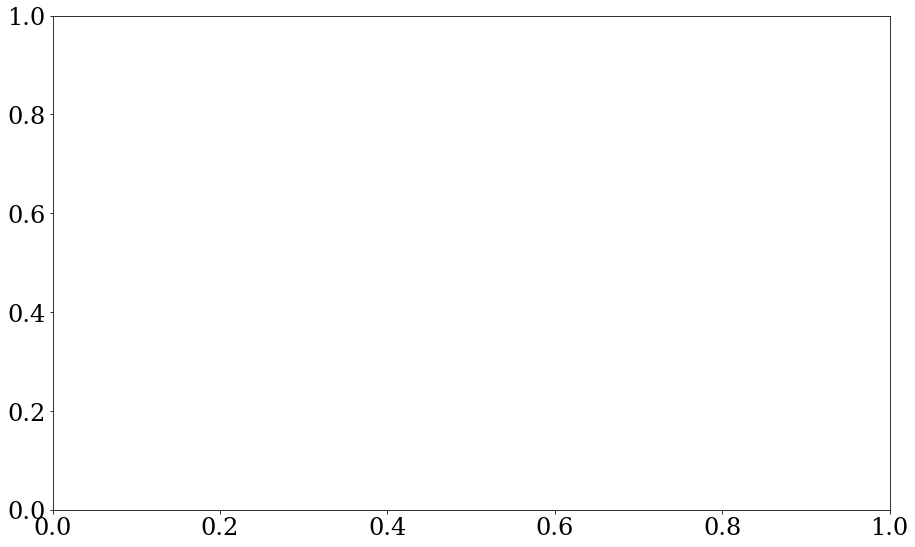

In [10]:
plt.rcParams.update({
    'lines.linewidth':2.0,
    'font.family':'serif',
    'font.size': 24,
    'legend.fontsize':20,
    'legend.frameon':False})

# Plot
fig = plt.figure()
fig.set_size_inches(15, 20)
ax = fig.add_subplot(2, 1, 1)

#plt.plot(bolshoi_m200c, mean_ncen, label='<N_cen>')
#plt.plot(bolshoi_m200c, mean_nsat, label='<N_sat>')
plt.plot(logM1_list, logMmin_list, linewidth = 4)

plt.title('$N_{gal} = 0.001\ (h^{-1}$ Mpc)$^{-3}$ iso-density curve \n (50 points, $N_{gal}$ error = $10^{-6}$)')
plt.xlabel(r'log $M_1$')
plt.ylabel(r'log $M_{min}$')
# ax.ticklabel_format(axis='y', style='sci', scilimits=(0,1))
# ax.set_xscale('log')
# ax.set_yscale('log')

'''
f = matplotlib.ticker.ScalarFormatter(useOffset=False, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.1e' % x))
plt.gca().yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(g))
'''

# plt.xlim([0.2*10**12,10**14])
# plt.ylim([0,7])

fig.patch.set_facecolor('white')

'''
lgnd = plt.legend(loc="upper left", scatterpoints=1)
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
'''

plt.show()